# Определение возраста покупателей ResNet50

## Краткое описание проекта

Сетевой супермаркет «Х» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении имеется набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [ ]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import warnings
warnings.simplefilter("ignore")

In [ ]:
os.getcwd()

'/home/jupyter/work/resources'

In [ ]:
# загрузка данных
labels = pd.read_csv('/home/jupyter/work/resources/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/home/jupyter/work/resources/final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [ ]:
features, target = next(train_gen_flow)

In [ ]:
features.shape

(32, 224, 224, 3)

In [ ]:
target.shape

(32,)

In [ ]:
type(target)

numpy.ndarray

In [ ]:
type(features)

numpy.ndarray

In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [ ]:
labels.median()

real_age    29.0
dtype: float64

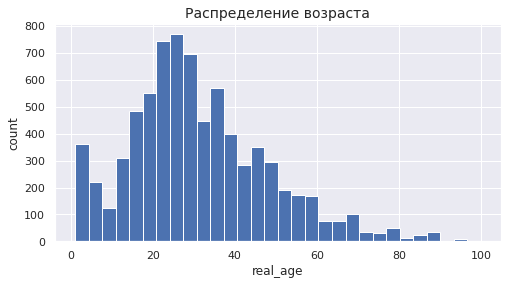

In [ ]:
sns.set(style="darkgrid")
labels['real_age'].plot(kind='hist', figsize=(8,4), bins=30)
plt.title("Распределение возраста", fontsize=14)
plt.xlabel("real_age")
plt.ylabel("count");

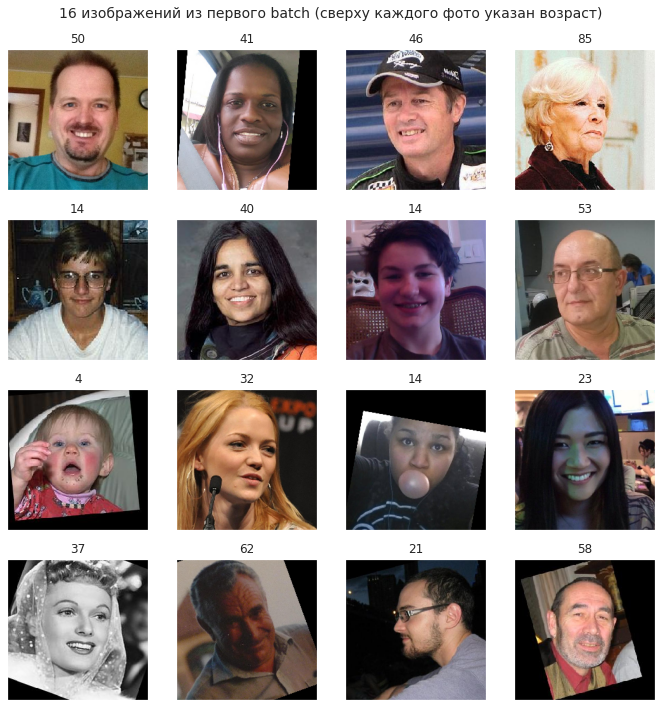

In [ ]:
# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
plt.suptitle("16 изображений из первого batch (сверху каждого фото указан возраст)", fontsize=14)
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    num = pd.DataFrame(target)[0][i]
    plt.title(num)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Вывод

**В результате исследовательского анализа, установлено:**

* общее число фотографий в датасете 7591;
* target_size=(224, 224);
* batch_size=32;
* распределение возрастов по типу Пуассона;
* среднее (31) значение смещено вправо относительно медианного (29);
* максимальный возраст - 100, минимальный - 1.

# Обучение модели

In [ ]:
def load_train(path):
    #labels = pd.read_csv(path)
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255, horizontal_flip=True,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 
 
    return train_gen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
   # labels = pd.read_csv(path)
    test_datagen = ImageDataGenerator(validation_split = 0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
 
    return test_gen_flow

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/home/jupyter/work/resources/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    # замораживаем ResNet50 без верхушки
    #backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mae', 
                  metrics=['mape'])
    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
 
    model.fit(train_data, 
              validation_data= test_data,
              epochs=epochs,
              steps_per_epoch=len(train_data),
              validation_steps=len(test_data),
              verbose=2)
 
    return model 

In [ ]:
input_shape=(224, 224, 3)

In [ ]:
#!g1.4
%%time
train_model(create_model(input_shape),
            load_train('/home/jupyter/work/resources/'),
            load_test('/home/jupyter/work/resources/'),
            batch_size=None, epochs=7, steps_per_epoch=None, validation_steps=None)

2022-09-09 23:51:44.454742: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 23:51:47.492950: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30995 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0
2022-09-09 23:51:47.497482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30995 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0
2022-09-09 23:51:47.501487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:

Found 5694 validated image filenames.
Found 1897 validated image filenames.


2022-09-09 23:51:57.517282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-09-09 23:52:03.245192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


178/178 - 88s - loss: 11.4484 - mape: 52.8966 - val_loss: 20.8583 - val_mape: 89.1753
Epoch 2/7
178/178 - 77s - loss: 7.6272 - mape: 38.5009 - val_loss: 22.5390 - val_mape: 82.9700
Epoch 3/7
178/178 - 74s - loss: 6.8207 - mape: 34.7290 - val_loss: 12.9494 - val_mape: 89.5773
Epoch 4/7
178/178 - 75s - loss: 6.3138 - mape: 30.8463 - val_loss: 13.2814 - val_mape: 47.5755
Epoch 5/7
178/178 - 75s - loss: 5.8923 - mape: 28.8803 - val_loss: 6.9184 - val_mape: 38.3723
Epoch 6/7
178/178 - 76s - loss: 5.6690 - mape: 27.0735 - val_loss: 6.5204 - val_mape: 35.2173
Epoch 7/7
178/178 - 75s - loss: 5.3470 - mape: 24.6381 - val_loss: 6.6847 - val_mape: 32.4547
CPU times: user 9min 23s, sys: 31.2 s, total: 9min 54s
Wall time: 9min 17s


## Вывод


**В результате обучения:**

1. Размер входного изображения: (224, 224, 3).
2. Применена аугментация: "горизонтальное отражение", "сдвиг по ширине и высоте".
3. Обучение проходило в 7 эпохах;
4. Время обучения составило порядка 9 минут на g1.4(32 cores, GPU: 4x V100) от Yandex Cloud.
5. Лучшее качество модели на валидационной выборке - val_loss: 6.6847 - val_mape: 32.4547;
6. Модель почти готова, так как дает порядка 68% точности, [при максимальных 75.9% на датасете ImageNet](https://habr.com/ru/post/347564/).

# Анализ модели

1. В качестве базовой модели взята модель ResNet50;
2. Архитектура ResNet взята без двух последних слоев;
3. Добавлены два последних слоя:GlobalAveragePooling2D и Dense (функция активации: 'relu');
4. Функция потерь: MAE, метрика качества: MAPE;
5. В качестве итерационного метода для оптимизации целевой функции взят:  'adam' с шагом: 0.0001.